In [2]:

import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to your PlantVillage dataset
data_dir = r"C:\Users\ravan\Downloads\archive (2)\PlantVillage\PlantVillage"  

# Image configuration
img_height, img_width = 128, 128
batch_size = 32

# Create ImageDataGenerator instances
datagen = ImageDataGenerator(
    rescale=1./255,          # normalize pixel values
    validation_split=0.2     # 20% for validation
)

# Training set
train_data = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',   # for CNN, one-hot
    subset='training',
    shuffle=True
)

# Validation set
val_data = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# Show class indices
print("\n Class Labels Mapping:")
print(train_data.class_indices)


Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.

🔍 Class Labels Mapping:
{'Pepper__bell___Bacterial_spot': 0, 'Pepper__bell___healthy': 1, 'Potato___Early_blight': 2, 'Potato___Late_blight': 3, 'Potato___healthy': 4, 'Tomato_Bacterial_spot': 5, 'Tomato_Early_blight': 6, 'Tomato_Late_blight': 7, 'Tomato_Leaf_Mold': 8, 'Tomato_Septoria_leaf_spot': 9, 'Tomato_Spider_mites_Two_spotted_spider_mite': 10, 'Tomato__Target_Spot': 11, 'Tomato__Tomato_YellowLeaf__Curl_Virus': 12, 'Tomato__Tomato_mosaic_virus': 13, 'Tomato_healthy': 14}


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the number of classes
num_classes = train_data.num_classes

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')  # 15 classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Checkpoint to save best model
checkpoint = ModelCheckpoint("cnn_model.keras", save_best_only=True, monitor='val_accuracy', mode='max')

# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=19,               
    callbacks=[checkpoint]
)


Epoch 1/19
517/517 ━━━━━━━━━━━━━━━━━━━━ 197s 372ms/step - accuracy: 0.3900 - loss: 1.8644 - val_accuracy: 0.7705 - val_loss: 0.7044
Epoch 2/19
517/517 ━━━━━━━━━━━━━━━━━━━━ 203s 393ms/step - accuracy: 0.7340 - loss: 0.7793 - val_accuracy: 0.8227 - val_loss: 0.5428
Epoch 3/19
517/517 ━━━━━━━━━━━━━━━━━━━━ 226s 436ms/step - accuracy: 0.8114 - loss: 0.5648 - val_accuracy: 0.8746 - val_loss: 0.3573
Epoch 4/19
517/517 ━━━━━━━━━━━━━━━━━━━━ 217s 419ms/step - accuracy: 0.8517 - loss: 0.4272 - val_accuracy: 0.8933 - val_loss: 0.3241
Epoch 5/19
517/517 ━━━━━━━━━━━━━━━━━━━━ 195s 377ms/step - accuracy: 0.8780 - loss: 0.3497 - val_accuracy: 0.8954 - val_loss: 0.3155
Epoch 6/19
517/517 ━━━━━━━━━━━━━━━━━━━━ 209s 403ms/step - accuracy: 0.9026 - loss: 0.2770 - val_accuracy: 0.9073 - val_loss: 0.2904
Epoch 7/19
517/517 ━━━━━━━━━━━━━━━━━━━━ 261s 506ms/step - accuracy: 0.9172 - loss: 0.2409 - val_accuracy: 0.9071 - val_loss: 0.2881
Epoch 8/19
517/517 ━━━━━━━━━━━━━━━━━━━━ 195s 378ms/step - accuracy: 0.9213 -

In [9]:
import numpy as np
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input

# Load the trained model
cnn_model = load_model("cnn_model.keras")

# Rebuild model with input tensor (for feature extraction)
# Get input shape from the model
input_shape = (128, 128, 3)
input_tensor = Input(shape=input_shape)

# Pass input through each layer manually
x = input_tensor
for layer in cnn_model.layers[:-1]:  # Exclude last softmax layer
    x = layer(x)

# Create new model for feature extraction
feature_model = Model(inputs=input_tensor, outputs=x)

# Image settings
img_height, img_width = 128, 128
batch_size = 32
data_dir = r"C:\Users\ravan\Downloads\archive (2)\PlantVillage\PlantVillage"   # Replace with your actual path

# Data generator (NO shuffle — important)
datagen = ImageDataGenerator(rescale=1./255)

all_data = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Extract features
features = feature_model.predict(all_data, verbose=1)
labels = all_data.classes

# Save features & labels
np.save("cnn_features.npy", features)
np.save("cnn_labels.npy", labels)

print("Features and labels saved: cnn_features.npy, cnn_labels.npy")


Found 20638 images belonging to 15 classes.
645/645 ━━━━━━━━━━━━━━━━━━━━ 222s 342ms/step
✅ Features and labels saved: cnn_features.npy, cnn_labels.npy


In [18]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import joblib

# Step 1: Load extracted features and labels
X = np.load("cnn_features.npy")
y = np.load("cnn_labels.npy")

print(f"Loaded features: {X.shape}, labels: {y.shape}")

# Step 2: Train-test split (for evaluating SVM)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Step 3: Train the SVM
svm_model = SVC(kernel='rbf', C=10, gamma='scale', probability=True)  # you can tune these
svm_model.fit(X_train, y_train)

print("SVM training complete.")

# Step 4: Evaluate the model
y_pred = svm_model.predict(X_test)



# Step 5: Save the trained SVM model
joblib.dump(svm_model, "svm_model.pkl")
print("SVM model saved as svm_model.pkl")


Loaded features: (20638, 128), labels: (20638,)
SVM training complete.
SVM model saved as svm_model.pkl


In [20]:
# CNN train and val accuracy
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]

print(f"Final CNN Training Accuracy: {train_acc * 100:.2f}%")
print(f"Final CNN Validation Accuracy: {val_acc * 100:.2f}%")


Final CNN Training Accuracy: 97.21%
Final CNN Validation Accuracy: 92.55%


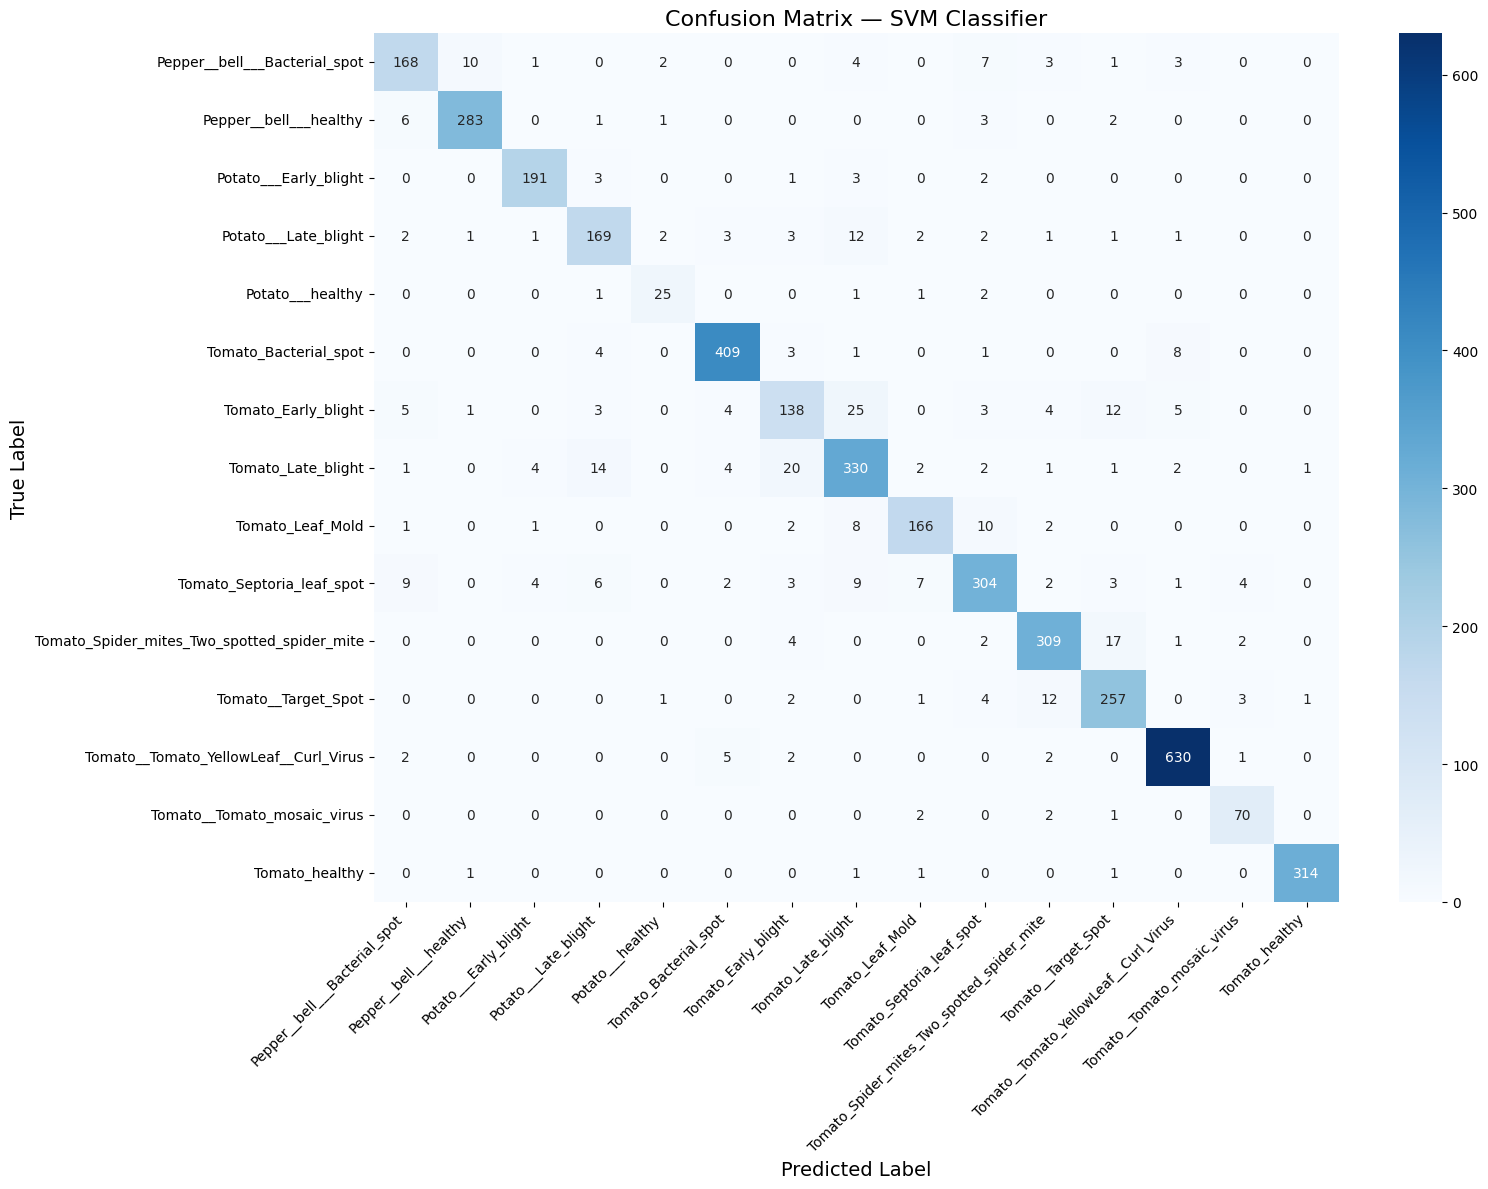

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Class names
class_names = list(all_data.class_indices.keys())

# Increase figure size and adjust label font size
plt.figure(figsize=(16, 12))  # Bigger figure
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names,
            annot_kws={"size": 10})  # Annotation text size

plt.title("Confusion Matrix — SVM Classifier", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)

# Rotate x and y labels with better alignment and spacing
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

plt.tight_layout()
plt.show()


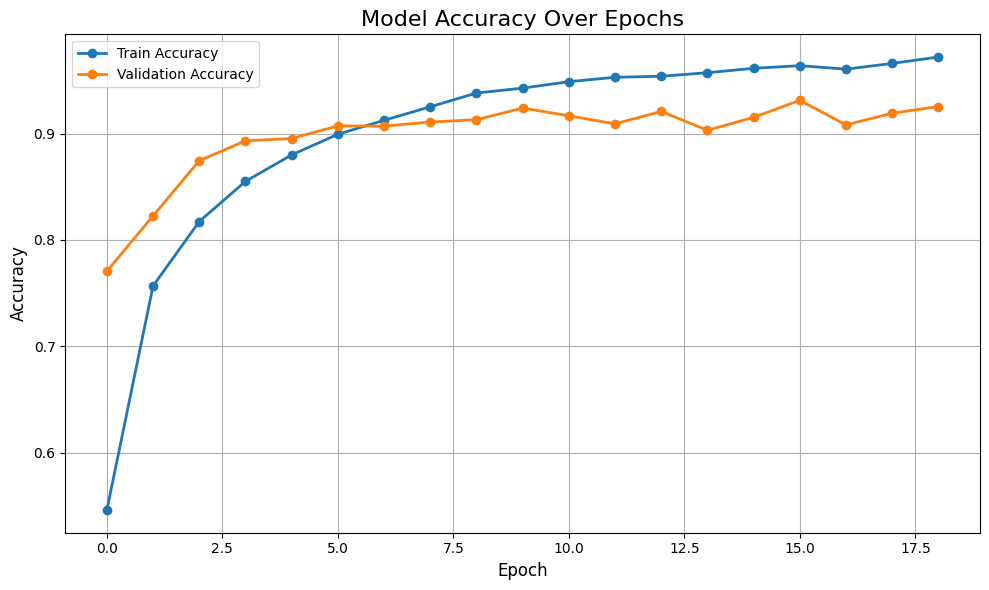

In [24]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(10, 6))  # Bigger figure size
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o', linewidth=2)
plt.title('Model Accuracy Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


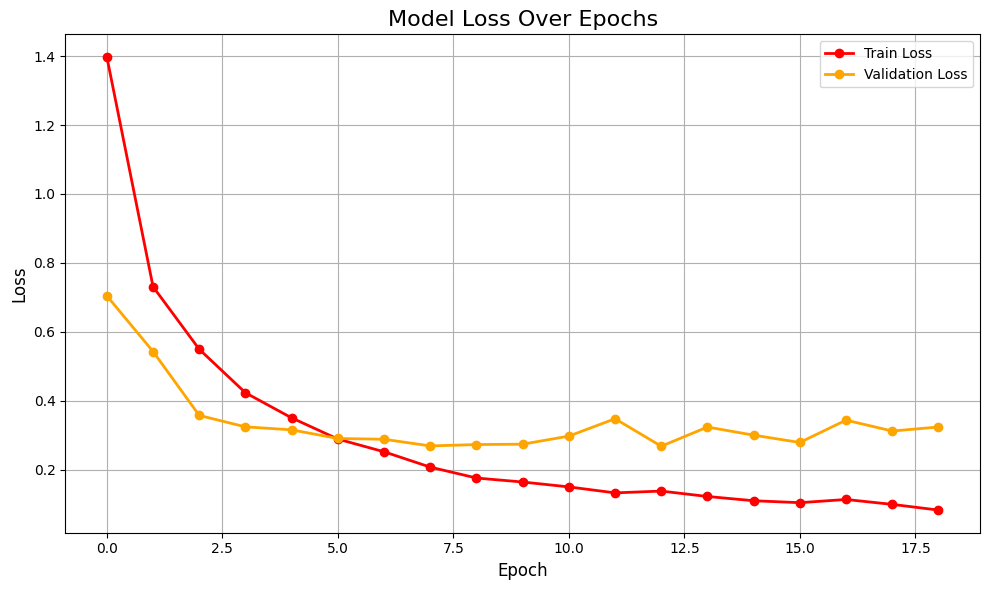

In [25]:
# Plot training & validation loss
plt.figure(figsize=(10, 6))  # Bigger figure size
plt.plot(history.history['loss'], label='Train Loss', marker='o', color='red', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o', color='orange', linewidth=2)
plt.title('Model Loss Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


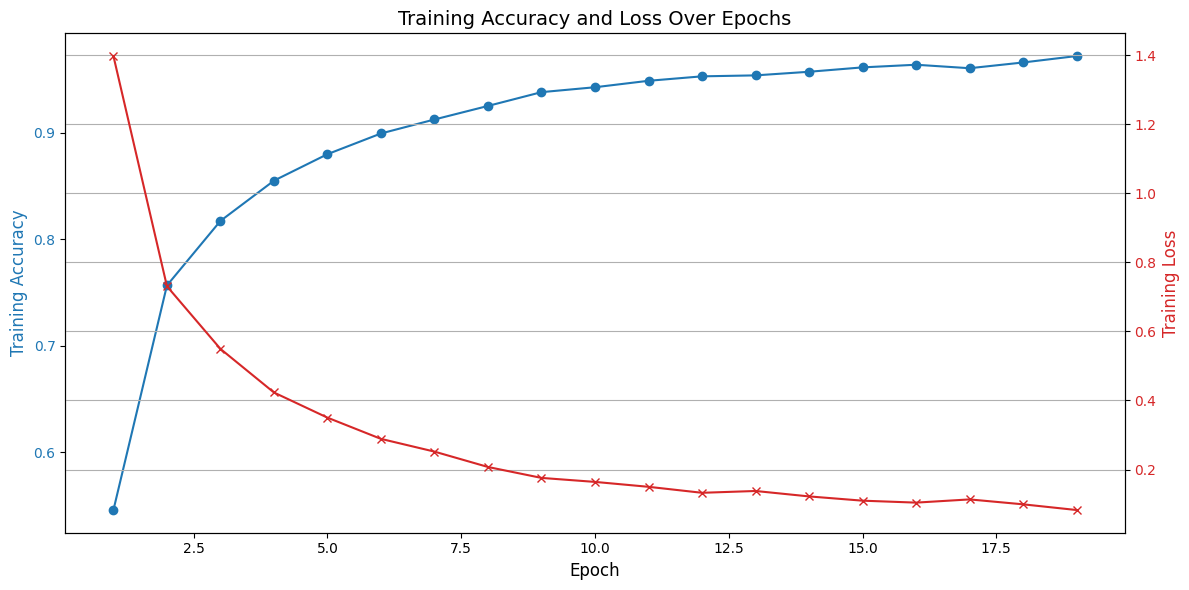

In [26]:
import matplotlib.pyplot as plt

# Extract metrics
epochs = range(1, len(history.history['accuracy']) + 1)
acc = history.history['accuracy']
loss = history.history['loss']

# Create figure
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot accuracy on left Y-axis
color = 'tab:blue'
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Training Accuracy', color=color, fontsize=12)
ax1.plot(epochs, acc, color=color, marker='o', label='Train Accuracy')
ax1.tick_params(axis='y', labelcolor=color)

# Plot loss on right Y-axis
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Training Loss', color=color, fontsize=12)
ax2.plot(epochs, loss, color=color, marker='x', label='Train Loss')
ax2.tick_params(axis='y', labelcolor=color)

# Title and layout
plt.title('Training Accuracy and Loss Over Epochs', fontsize=14)
fig.tight_layout()
plt.grid(True)
plt.show()


In [17]:
import numpy as np

per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
for idx, acc in enumerate(per_class_accuracy):
    print(f"{class_names[idx]}: {acc * 100:.2f}%")


Pepper__bell___Bacterial_spot: 84.42%
Pepper__bell___healthy: 95.61%
Potato___Early_blight: 95.50%
Potato___Late_blight: 84.50%
Potato___healthy: 83.33%
Tomato_Bacterial_spot: 96.01%
Tomato_Early_blight: 69.00%
Tomato_Late_blight: 86.39%
Tomato_Leaf_Mold: 87.37%
Tomato_Septoria_leaf_spot: 85.88%
Tomato_Spider_mites_Two_spotted_spider_mite: 92.24%
Tomato__Target_Spot: 91.46%
Tomato__Tomato_YellowLeaf__Curl_Virus: 98.13%
Tomato__Tomato_mosaic_virus: 93.33%
Tomato_healthy: 98.74%


In [27]:
accuracy = accuracy_score(y_test, y_pred)
print(f"\n CNN-SVM Test Accuracy: {accuracy * 100:.2f}%")


 CNN-SVM Test Accuracy: 91.16%


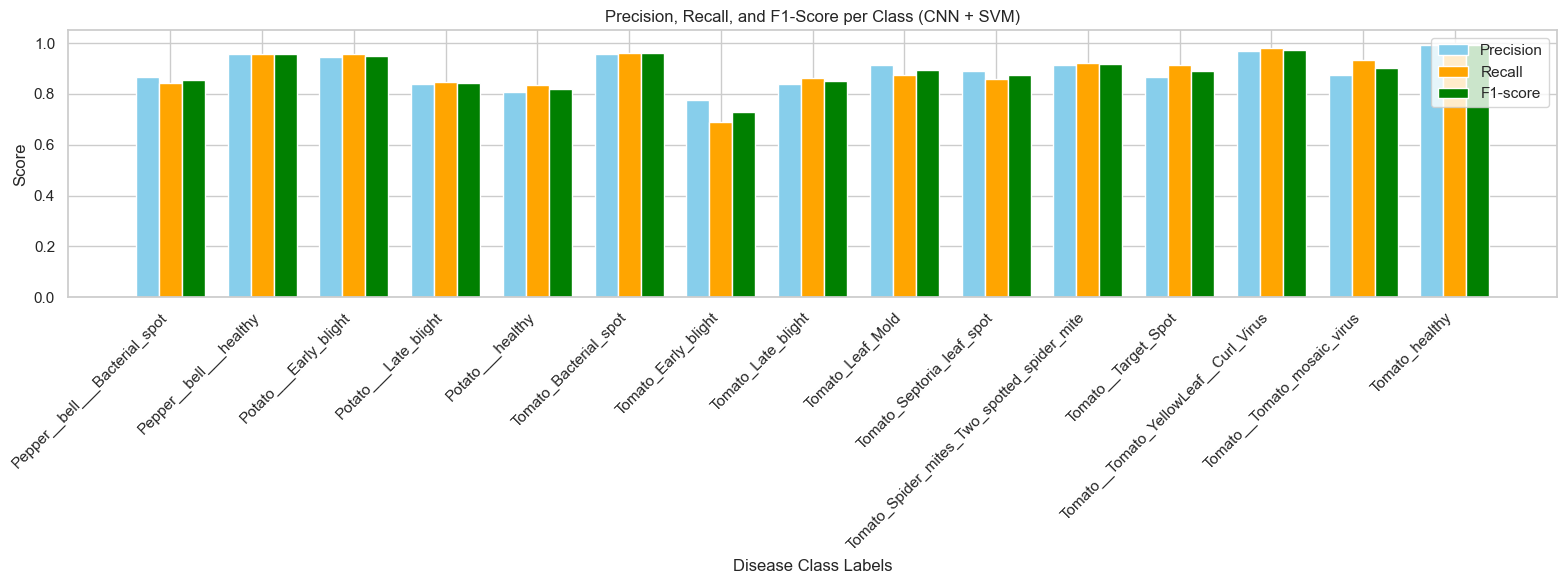

In [63]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Get class labels (from your dataset loader)
class_labels = list(all_data.class_indices.keys())  # Same order as flow_from_directory

# Get classification report
report = classification_report(y_test, y_pred, target_names=class_labels, output_dict=True)

# Extract metrics
precision = [report[label]['precision'] for label in class_labels]
recall = [report[label]['recall'] for label in class_labels]
f1 = [report[label]['f1-score'] for label in class_labels]

# Plotting the bar graph
import numpy as np
x = np.arange(len(class_labels))
width = 0.25

plt.figure(figsize=(16, 6))
plt.bar(x - width, precision, width=width, label='Precision', color='skyblue')
plt.bar(x, recall, width=width, label='Recall', color='orange')
plt.bar(x + width, f1, width=width, label='F1-score', color='green')

plt.xlabel("Disease Class Labels")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1-Score per Class (CNN + SVM)")
plt.xticks(ticks=x, labels=class_labels, rotation=45, ha='right')
plt.ylim(0, 1.05)
plt.legend()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


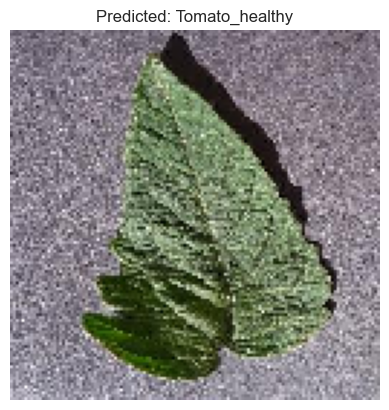

Predicted Disease: Tomato_healthy


In [59]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input
from sklearn.preprocessing import LabelEncoder
import joblib
import os

# Load trained CNN and SVM
cnn_model = load_model("cnn_model.keras")  # or "cnn_model.h5" if used that
svm_model = joblib.load("svm_model.pkl")

# Prepare feature extractor model (CNN without final softmax layer)
input_tensor = Input(shape=(128, 128, 3))
x = input_tensor
for layer in cnn_model.layers[:-1]:
    x = layer(x)
feature_model = Model(inputs=input_tensor, outputs=x)

# Class names
class_names = list(os.listdir(r"C:\Users\ravan\Downloads\archive (2)\PlantVillage\PlantVillage"))

# Load and preprocess image
def predict_disease(img_path):
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Extract features and predict
    features = feature_model.predict(img_array)
    pred = svm_model.predict(features)

    # Show image and prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {class_names[pred[0]]}")
    plt.show()

    print(f"Predicted Disease: {class_names[pred[0]]}")

# Example usage
predict_disease(r"C:\Users\ravan\Downloads\archive (2)\PlantVillage\Tomato_healthy\fd75c626-bda9-4388-8b29-75d40ea7c6d4___RS_HL 0041.JPG")  # Replace with your own test image path
